# <div id="chap1">1. Import libraries

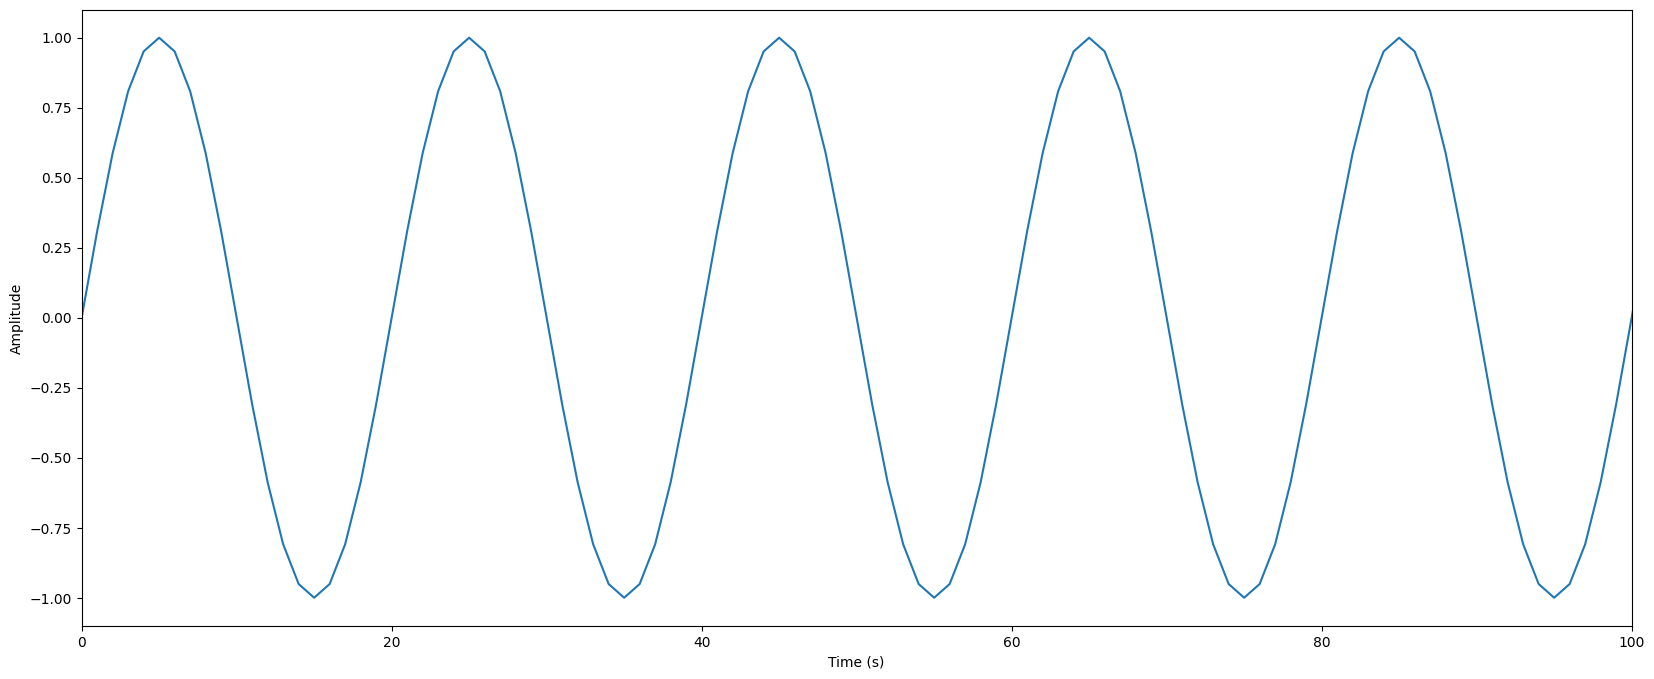

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 設定波形參數
amplitude = 1  # 振幅
frequency = 0.05  # 頻率
phase = 0      # 相位
duration = 6000   # 時間長度，單位為秒
sampling_rate = 1  # 取樣率，單位為 Hz

# 計算波形數據
time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
waveform = amplitude * np.sin(2 * np.pi * frequency * time + phase)

# 繪製波形圖
plt.figure(figsize=(20, 8))
plt.plot(waveform)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0,100)
plt.show()

In [2]:
len(waveform)

6000

In [3]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
# import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [4]:
import yfinance as yf

# <div id="chap2">2. Preprocessing

In [5]:
stock_name = "^GSPC"
date_predict_start = '2019-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 2
# n_harm_lower_limit = 1
# n_harm_upper_limit = 50
# fit_method = 'rmse'
# pv_method = 'CL'

In [6]:
COMPANY = '^GSPC'

In [7]:
data = yf.download(COMPANY, start='1999-01-01', end='2019-06-30')
len(data)

[*********************100%***********************]  1 of 1 completed


5155

In [8]:
data['Close'] = waveform[:len(data)]

In [9]:
array_data = np.array(data['Close'])
n_data = array_data.size
time_data = np.arange(0, n_data)
Polynomial = np.polyfit(time_data, array_data, 1)
data_notrend = array_data - Polynomial[0] * time_data  # detrended x
data['Close'] = data_notrend

In [10]:
train_data = data.loc[data.index < date_predict_start]
print(len(train_data))
test_data = data.loc[data.index > date_predict_start]
print(len(test_data))

5031
124


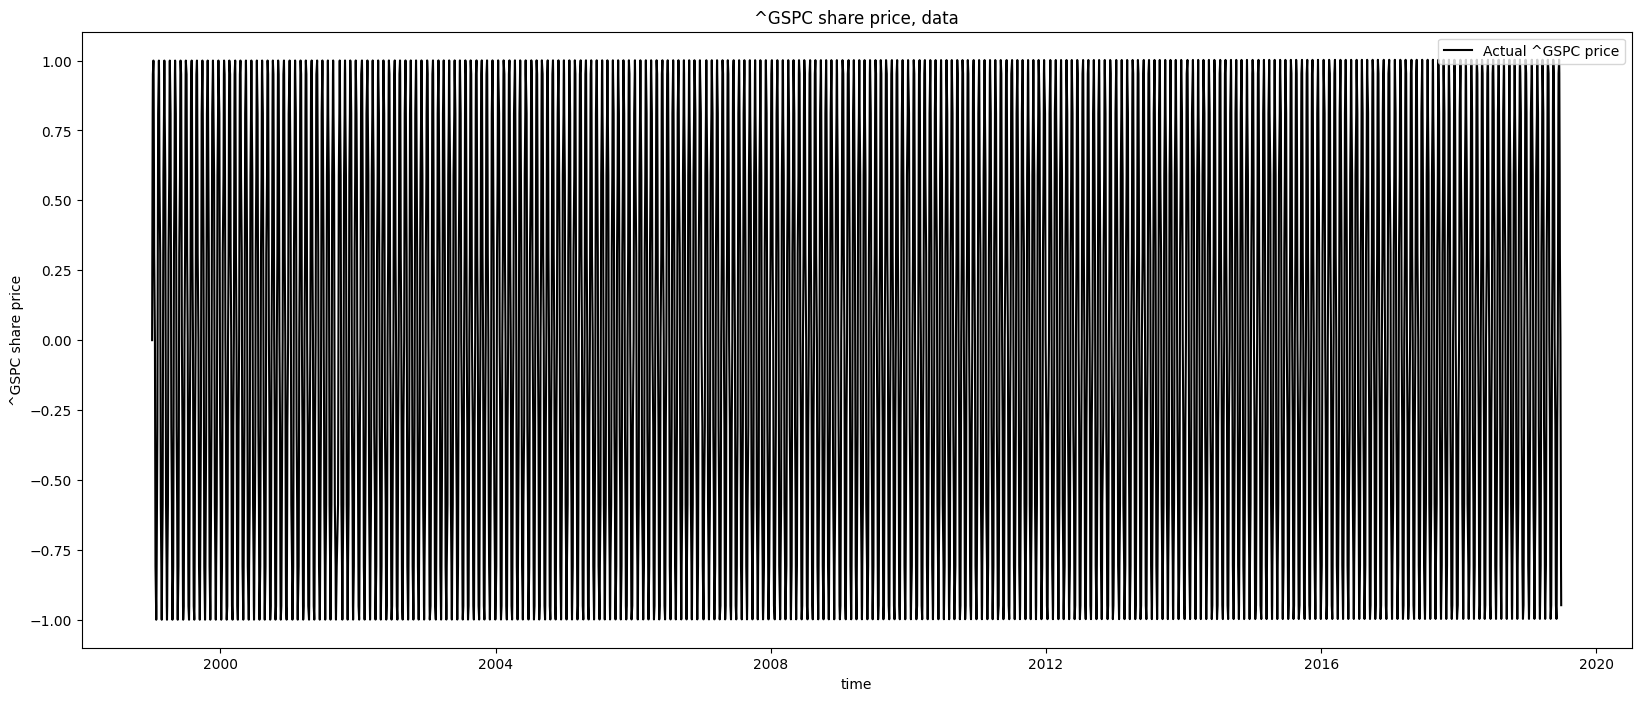

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, data")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

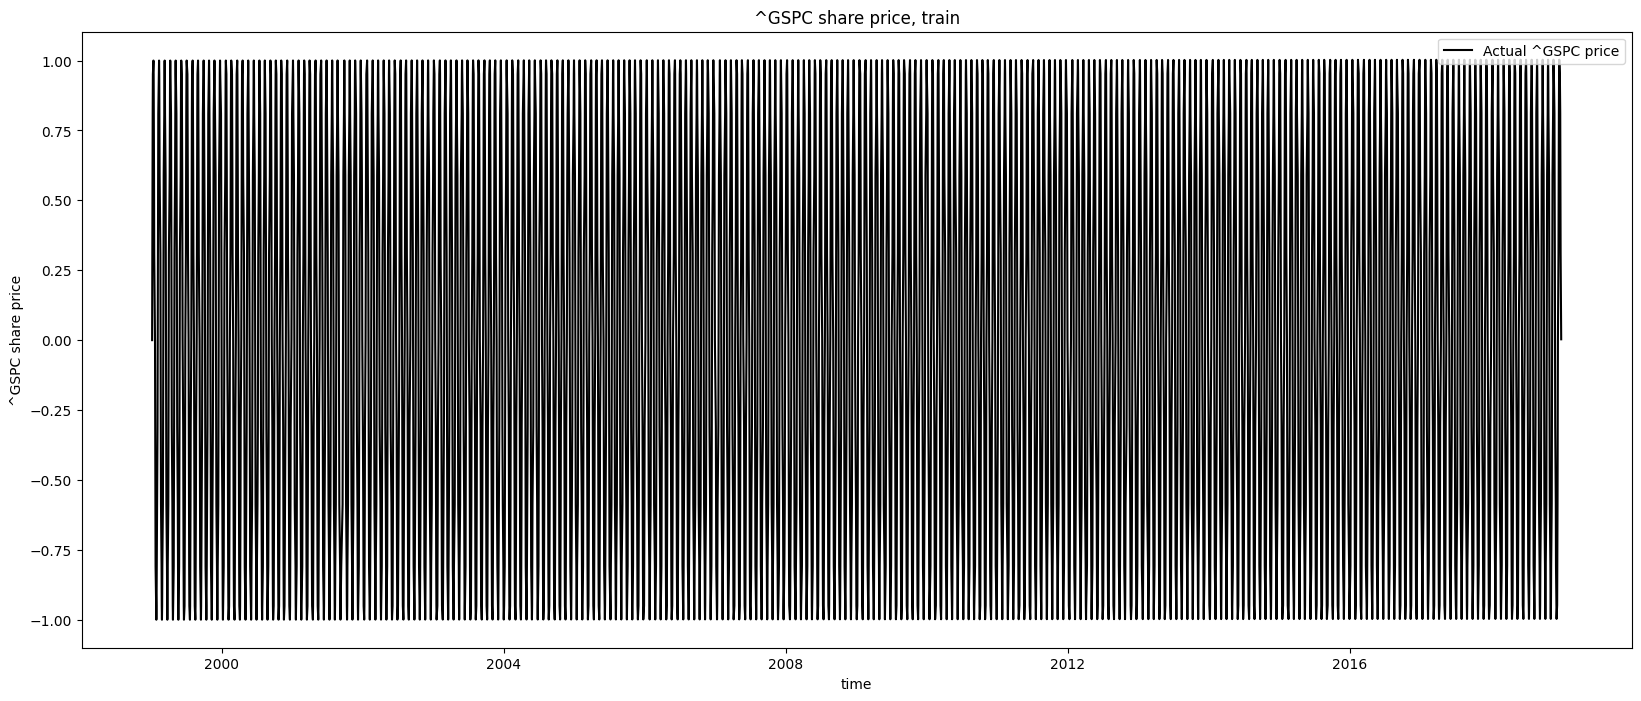

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(train_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, train")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

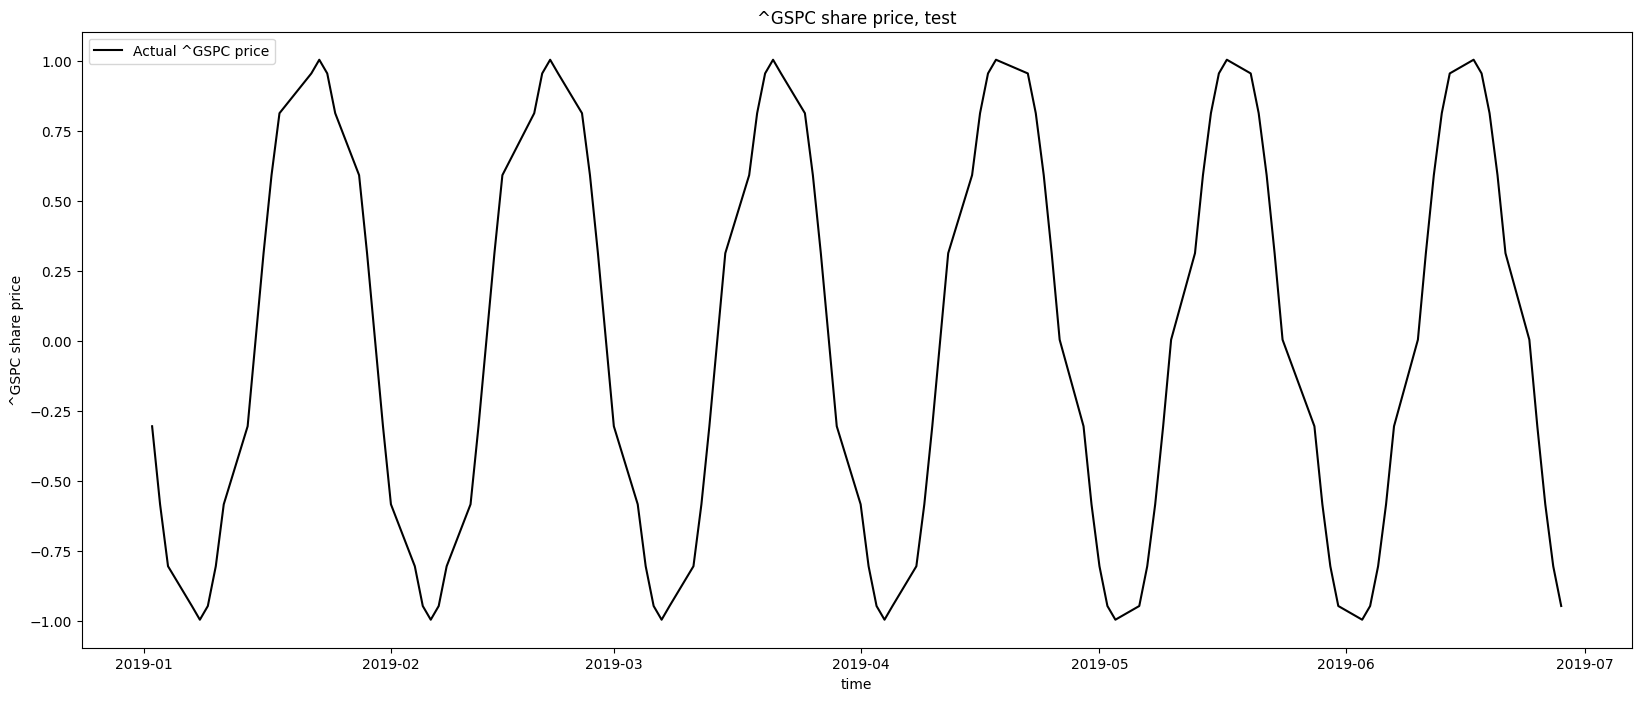

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(test_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, test")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [14]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

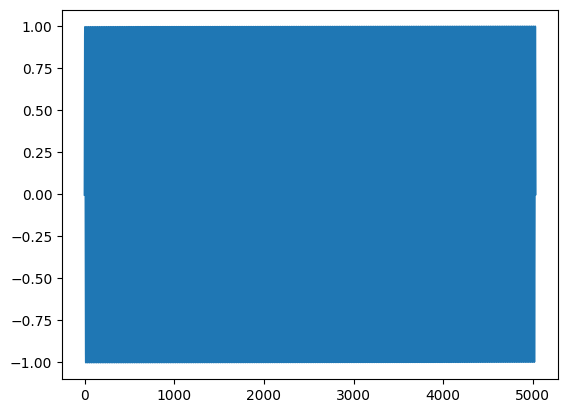

In [15]:
plt.plot(scaled_data)

In [16]:
# how many days do i want to base my predictions on ?
base_day = 250
prediction_day = 30
x_train = []
y_train = []
slide = 10
# 從base_day開始，往前提取base_day天的數據，作為輸入變量x_train，並將當前價格作為輸出變量y_train
for x in range(base_day+prediction_day, len(scaled_data), slide):
    x_train.append(scaled_data[x-base_day-prediction_day:x-prediction_day, 0])
    y_train.append(scaled_data[x-prediction_day:x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [17]:
x_train.shape

(476, 250, 1)

In [18]:
y_train.shape

(476, 30, 1)

# <div id="chap3">3. Build LSTM model

In [19]:
def LSTM_model(prediction_day):
    
    model = Sequential()
    
    model.add(LSTM(units = 256, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    
    model.add(Dense(units=prediction_day))
    
    return model

# <div id="chap4">4. Training

In [20]:
# model = LSTM_model()
# model.summary()
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define callbacks
# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
# earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

# history = model.fit(x_train, y_train, epochs=25, batch_size = 32, callbacks = [checkpointer, earlystopper], validation_split = 0.2)

# # plot loss curves
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()


In [21]:
model = LSTM_model(prediction_day)
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 256)          264192    
                                                                 
 dropout (Dropout)           (None, 250, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 250, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 250, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 30)                1

In [22]:
# # Define callbacks

# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
#                                verbose = 2, 
#                                save_best_only = True)

# model.fit(x_train, 
#           y_train, 
#           epochs=25, 
#           batch_size = 32,
#           callbacks = [checkpointer])

In [23]:
# Define callbacks
# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 2)
history = model.fit(x_train, y_train, epochs=25, batch_size=32, callbacks = [checkpointer, earlystopper], validation_split = 0.2, shuffle=True)


Epoch 1/25
12/12 [==============================] - ETA: 0s - loss: 0.3452
Epoch 1: val_loss improved from inf to 0.12607, saving model to weights_best.hdf5
12/12 [==============================] - 28s 2s/step - loss: 0.3452 - val_loss: 0.1261
Epoch 2/25
12/12 [==============================] - ETA: 0s - loss: 0.1343
Epoch 2: val_loss improved from 0.12607 to 0.02468, saving model to weights_best.hdf5
12/12 [==============================] - 20s 2s/step - loss: 0.1343 - val_loss: 0.0247
Epoch 3/25
12/12 [==============================] - ETA: 0s - loss: 0.0801
Epoch 3: val_loss improved from 0.02468 to 0.00944, saving model to weights_best.hdf5
12/12 [==============================] - 24s 2s/step - loss: 0.0801 - val_loss: 0.0094
Epoch 4/25
12/12 [==============================] - ETA: 0s - loss: 0.0617
Epoch 4: val_loss improved from 0.00944 to 0.00391, saving model to weights_best.hdf5
12/12 [==============================] - 25s 2s/step - loss: 0.0617 - val_loss: 0.0039
Epoch 5/25
1

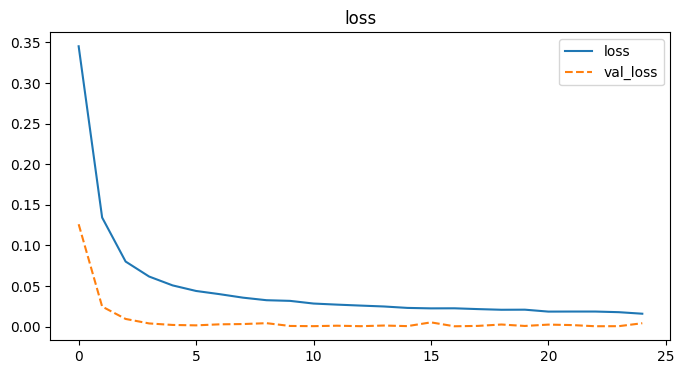

In [24]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()



# <div id="chap5">5. Predictions

In [25]:
# test model accuracy on existing data

actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-base_day:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

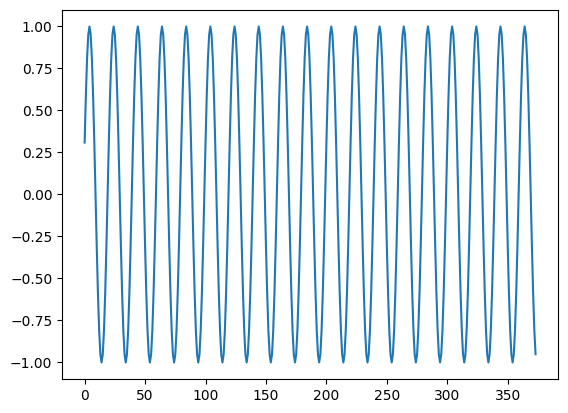

In [26]:
plt.plot(model_inputs)

In [27]:
x_test = []
y_test = []
for x in range(base_day+prediction_day, len(model_inputs), slide):
    x_test.append(model_inputs[x-base_day-prediction_day:x-prediction_day, 0])
    y_test.append(model_inputs[x-prediction_day:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
# predicted_prices = scaler.inverse_transform(predicted_prices)
print(f"predicted_prices: {predicted_prices}")

1/1 [==============================] - 2s 2s/step
predicted_prices: [[ 0.01646652 -0.2831413  -0.4542132  -0.64234364 -0.82730603 -0.8540823
  -0.86812156 -0.72919345 -0.50806755 -0.26281223 -0.02641454  0.27348754
   0.517942    0.68469125  0.8287498   0.87890714  0.85372967  0.680174
   0.5050723   0.26462892 -0.01445183 -0.29234618 -0.50950515 -0.7586593
  -0.8482643  -0.8603637  -0.80562276 -0.7040855  -0.5117319  -0.3089453 ]
 [-0.00758666  0.2857836   0.46176267  0.6343639   0.8310033   0.8655604
   0.870664    0.7327021   0.5004428   0.26967117  0.01846066 -0.2746271
  -0.52934676 -0.68275464 -0.8200006  -0.87374264 -0.8623969  -0.6853604
  -0.49364978 -0.24996161  0.01646997  0.28391027  0.5100272   0.75395364
   0.8577439   0.8641683   0.81238914  0.7133151   0.53594315  0.30432895]
 [ 0.01646747 -0.2831409  -0.4542101  -0.64233726 -0.82730275 -0.8540804
  -0.8681217  -0.7291928  -0.50806445 -0.26281226 -0.02641556  0.2734873
   0.5179416   0.68468815  0.82874906  0.878905    

In [28]:
type(predicted_prices)

numpy.ndarray

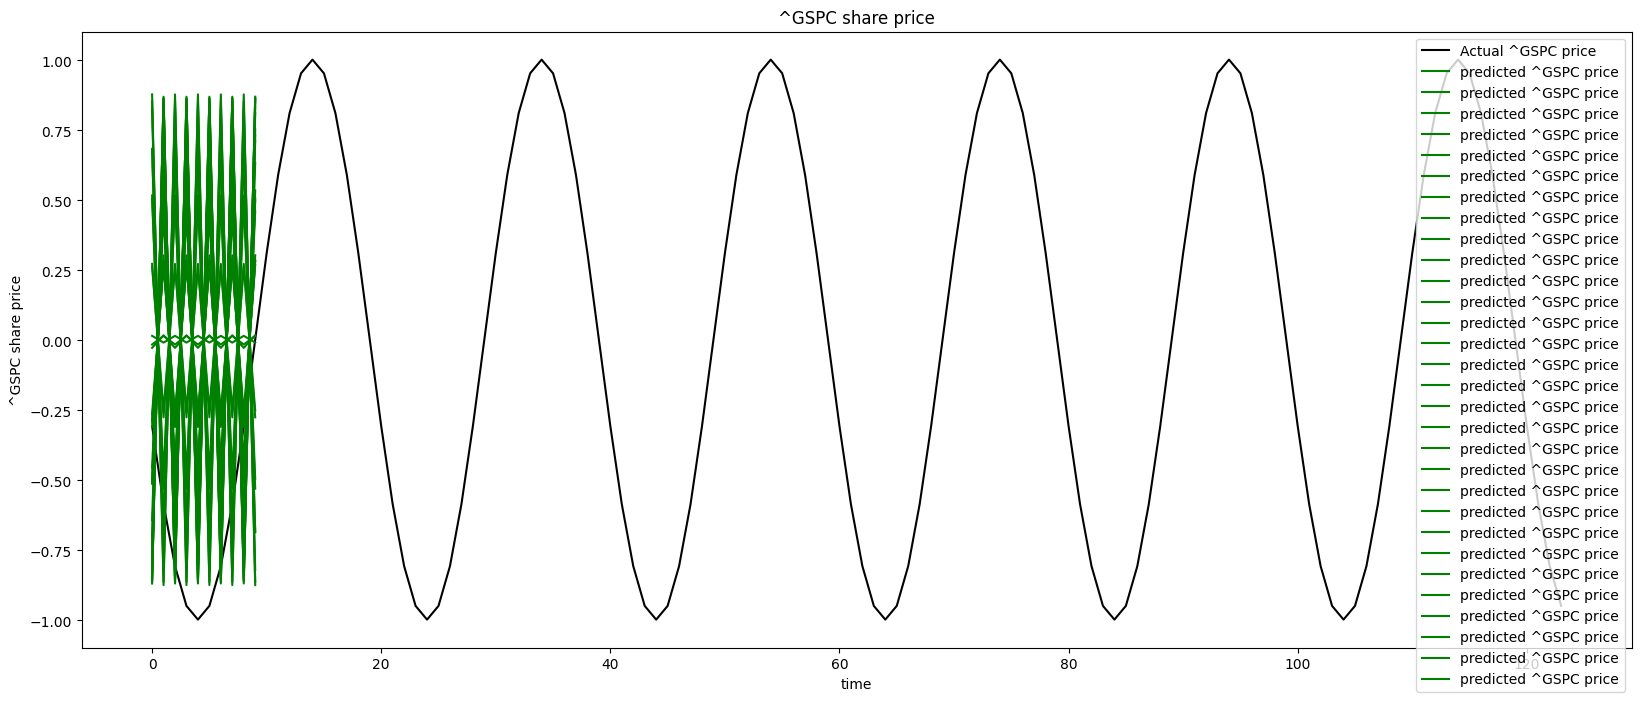

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color='green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

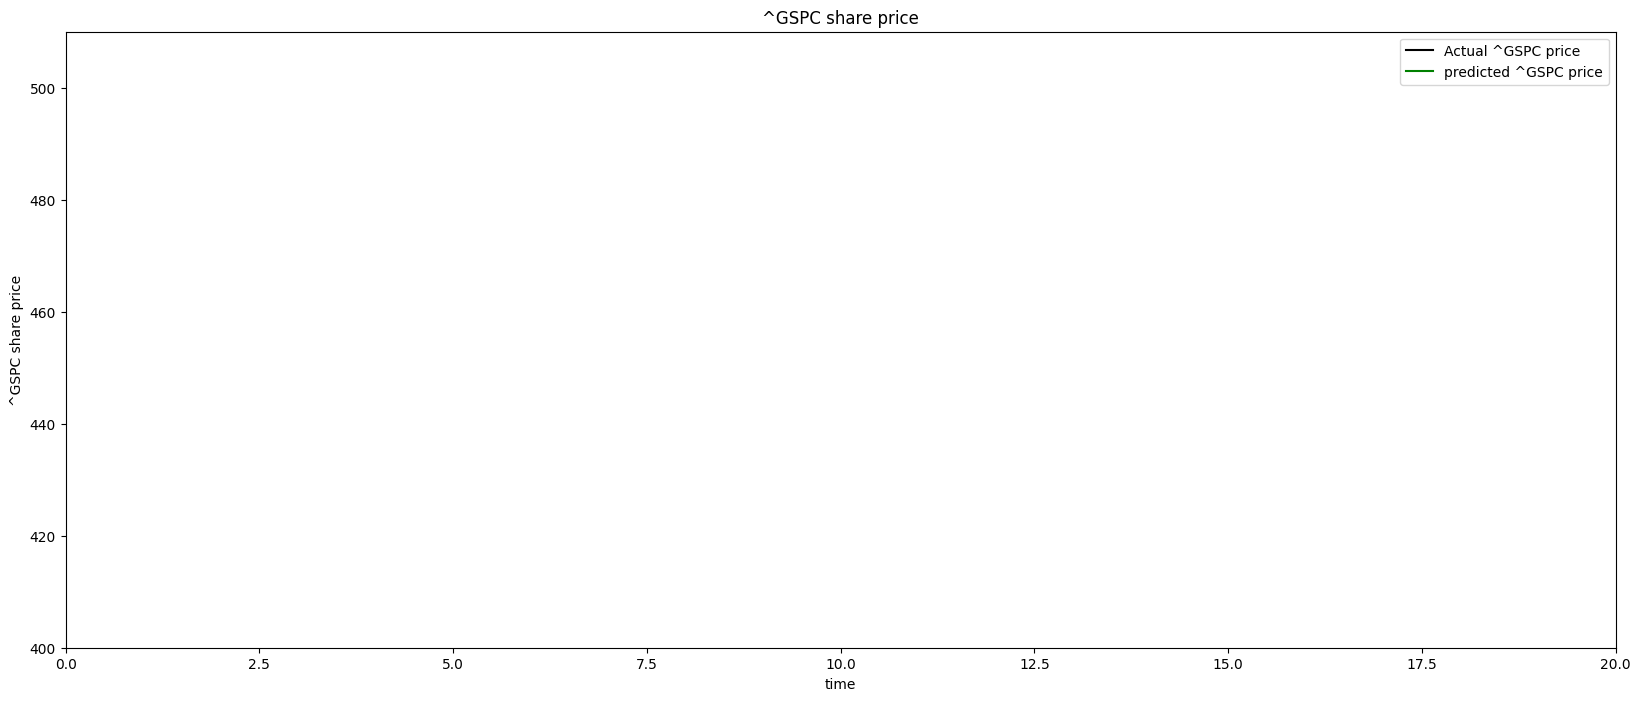

In [30]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices[0], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.xlim(0, 20)
plt.ylim(400, 510)
plt.legend()
plt.show()

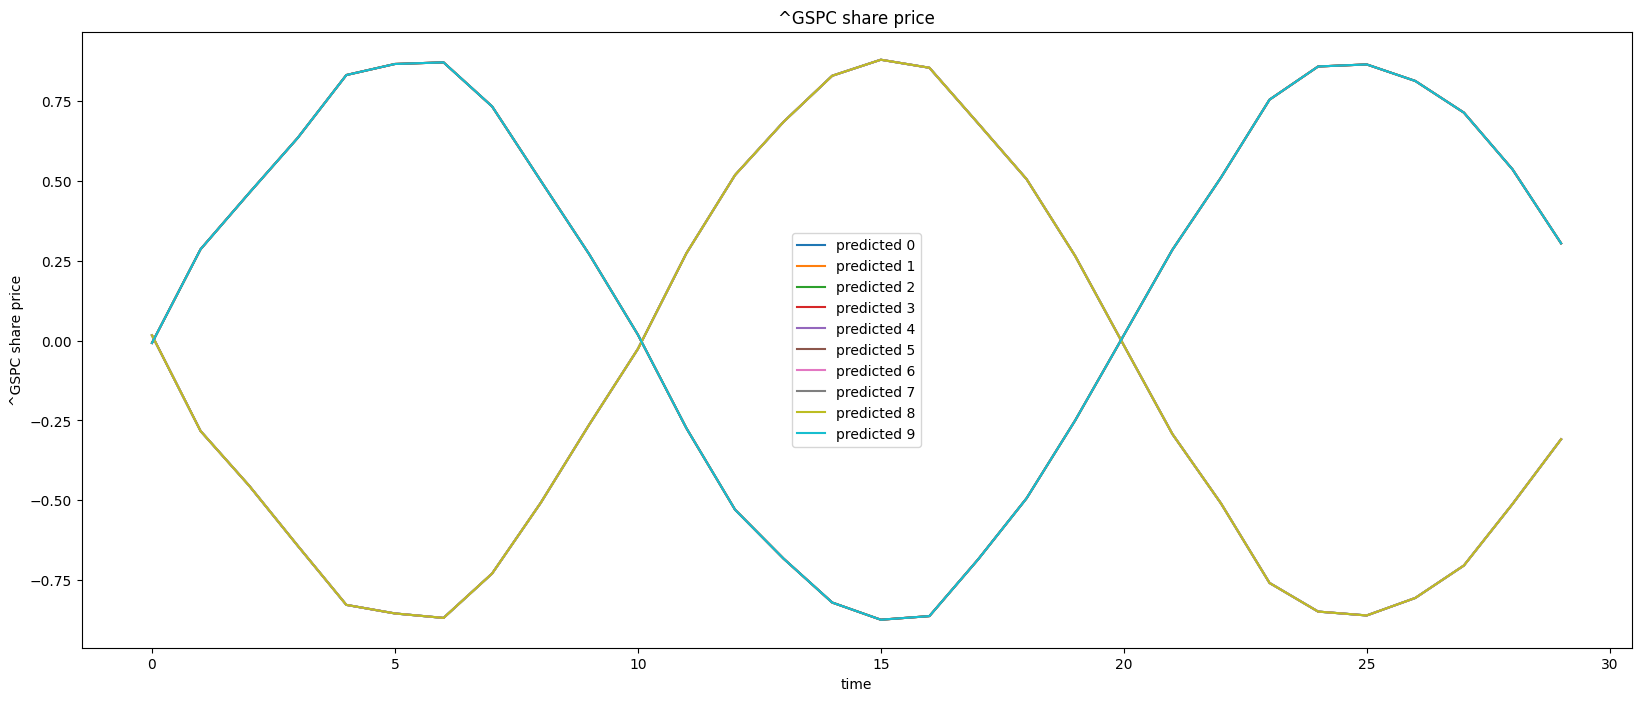

In [31]:
plt.figure(figsize=(20, 8))
for i in range(0, 10):
    plt.plot(predicted_prices[i], label=f"predicted {i}")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
# plt.xlim(0, 9)
# plt.ylim(400, 510)
plt.legend()
plt.show()

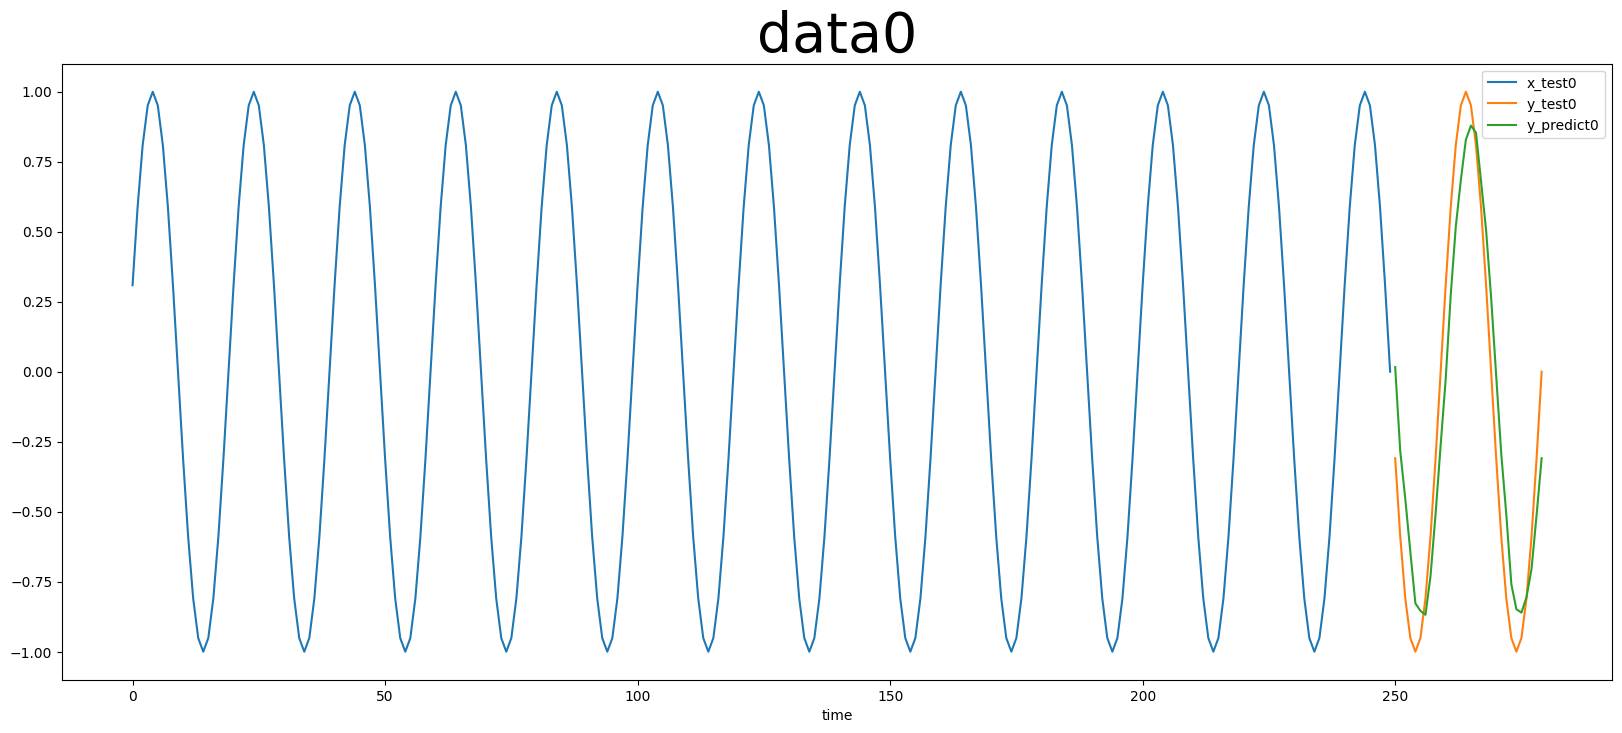

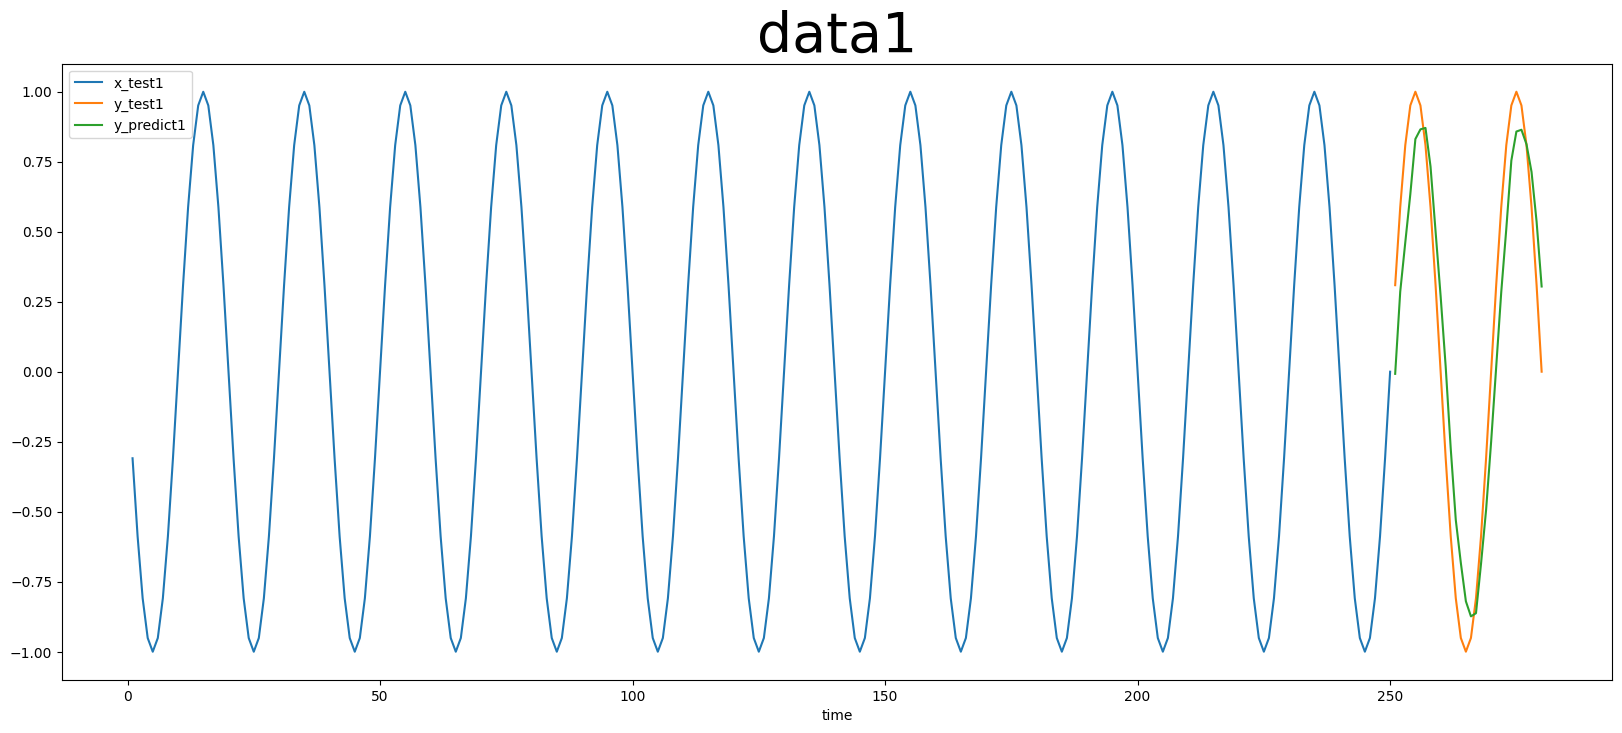

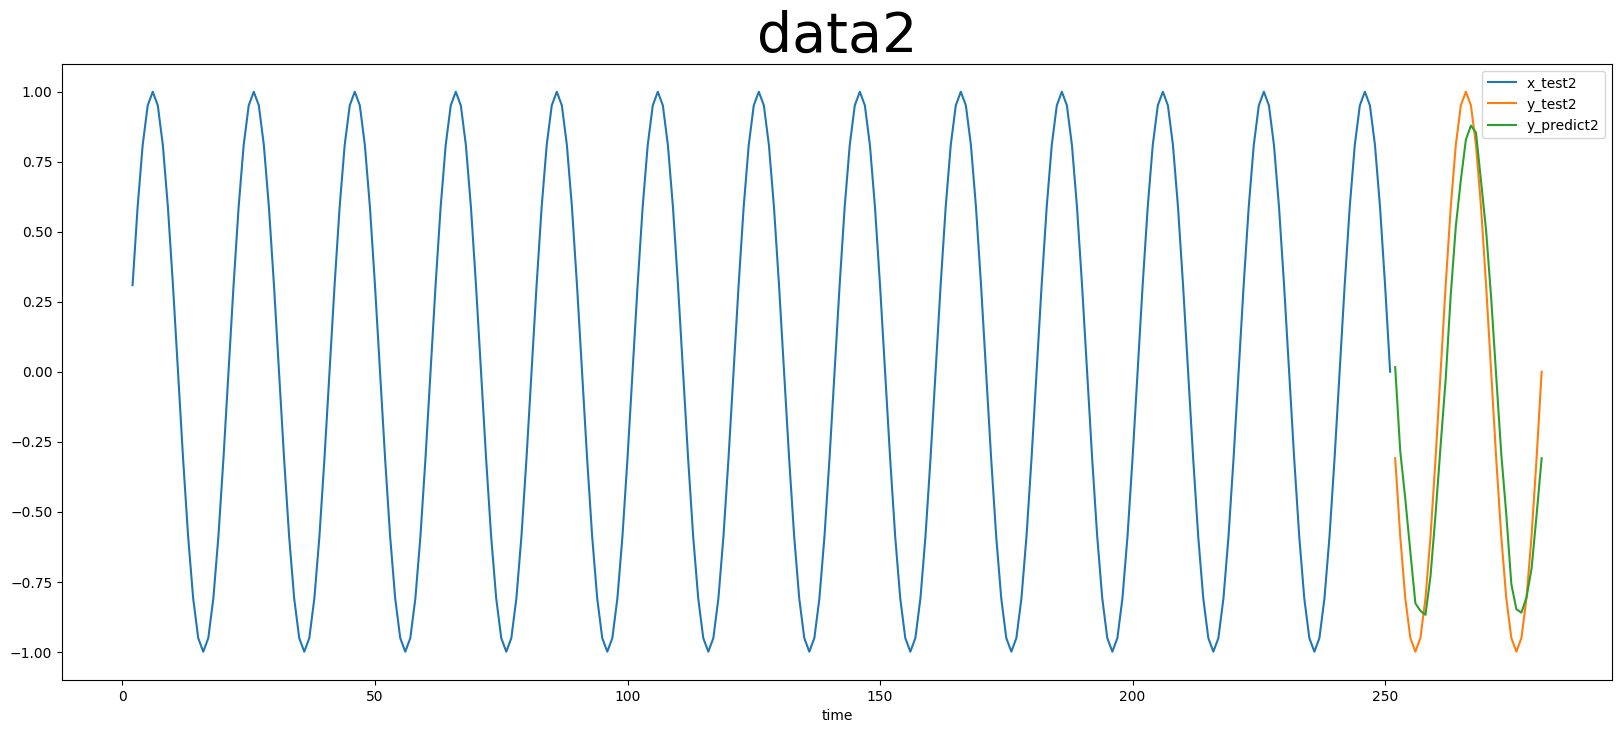

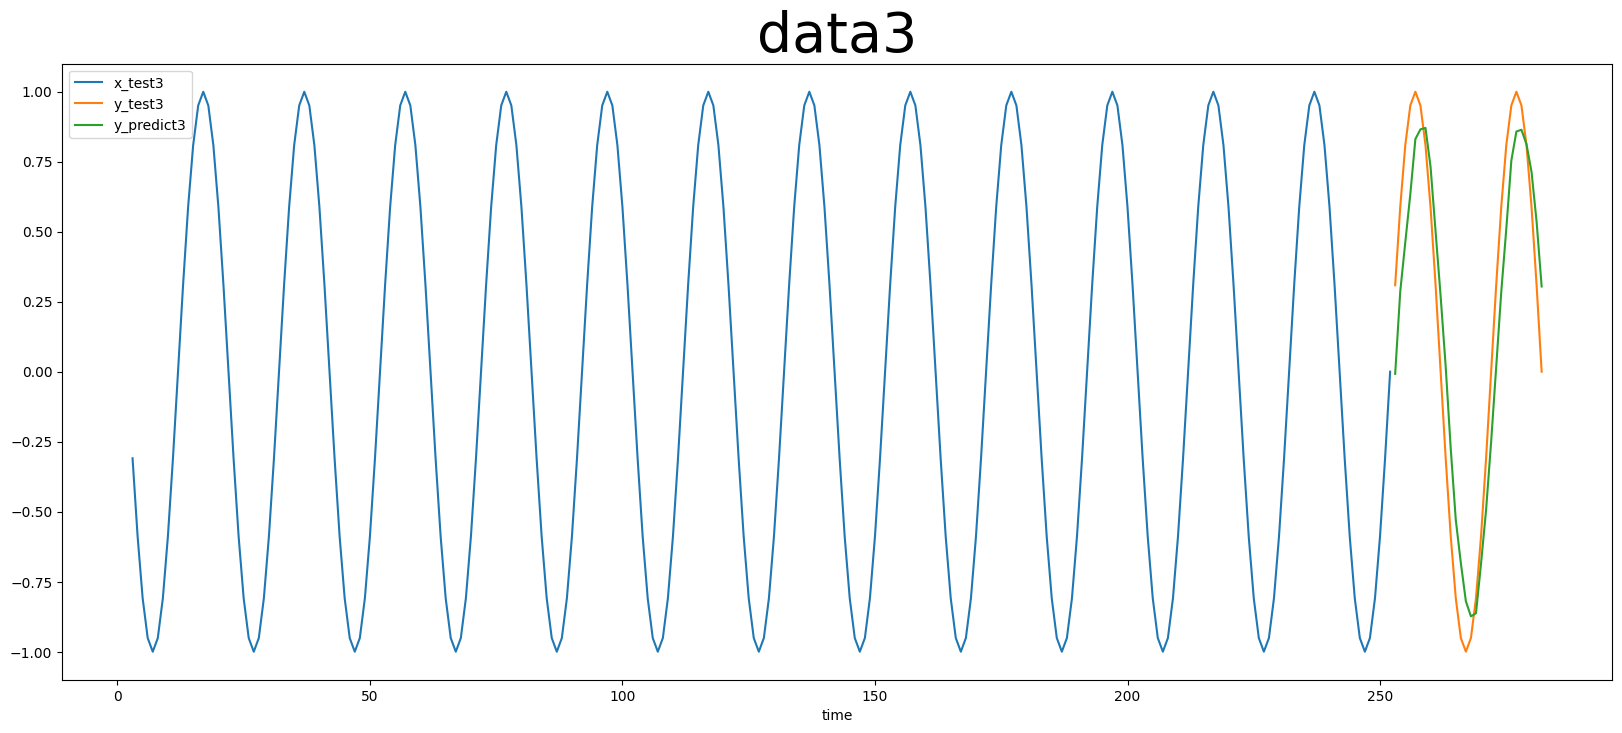

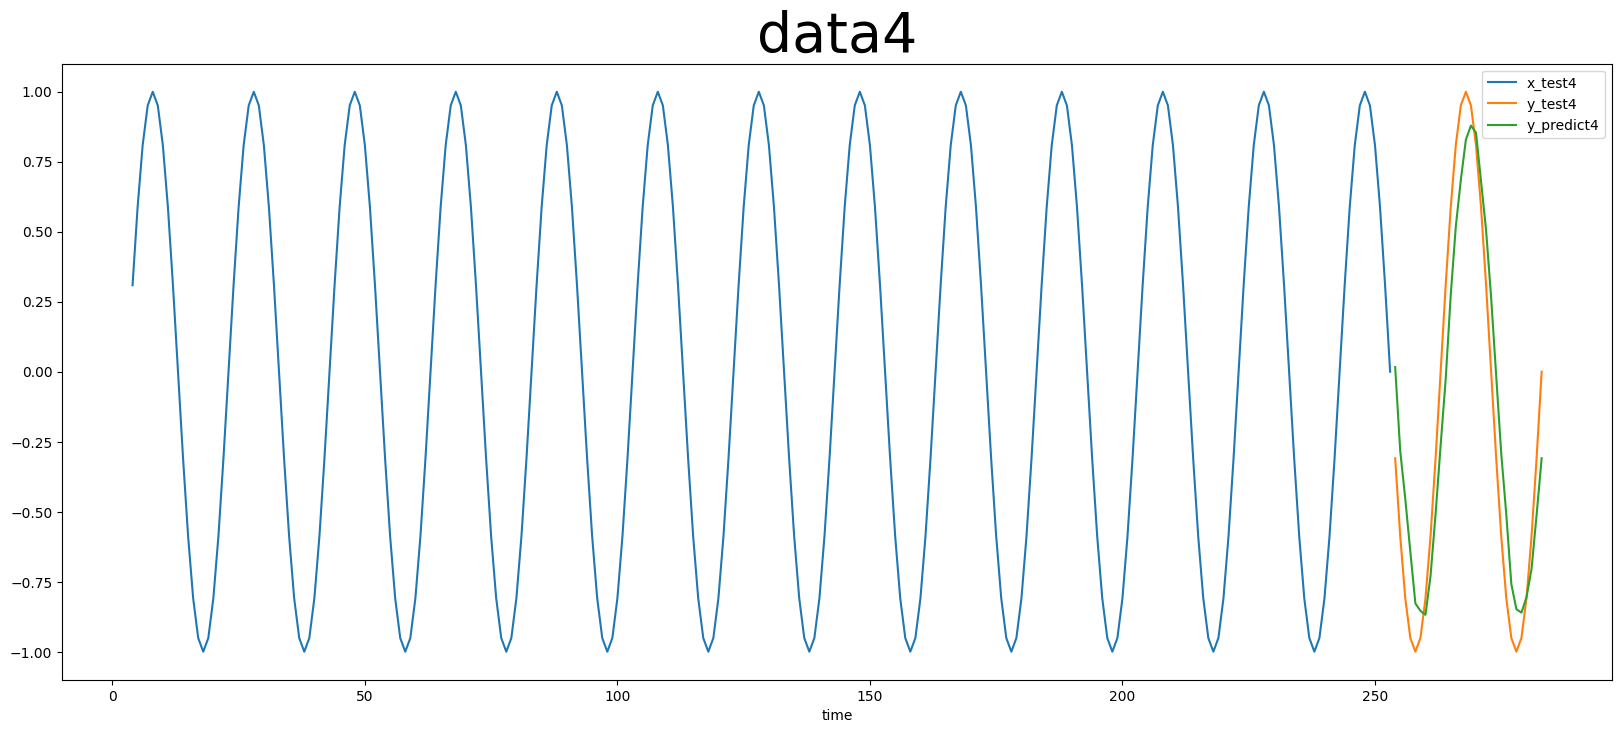

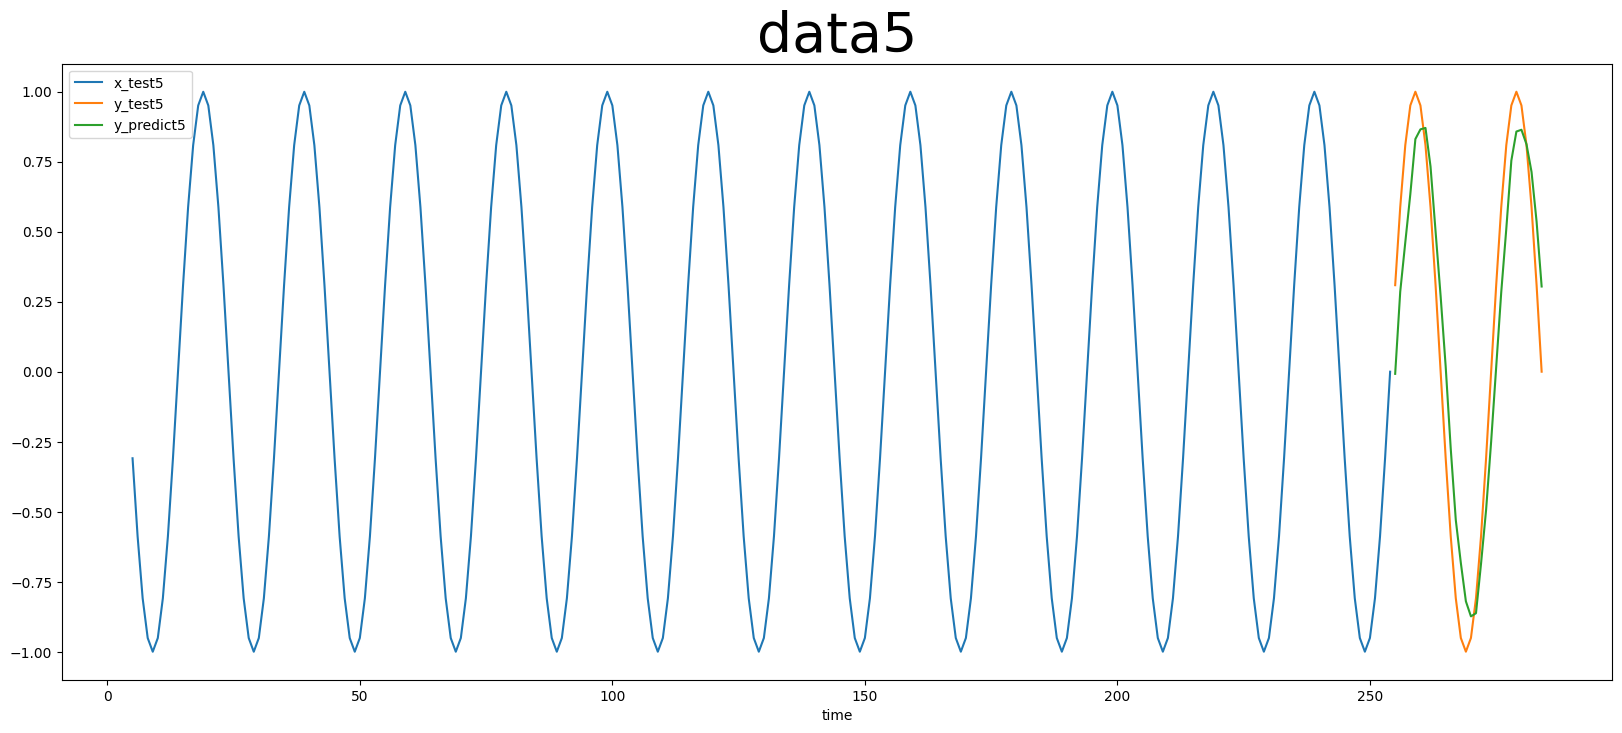

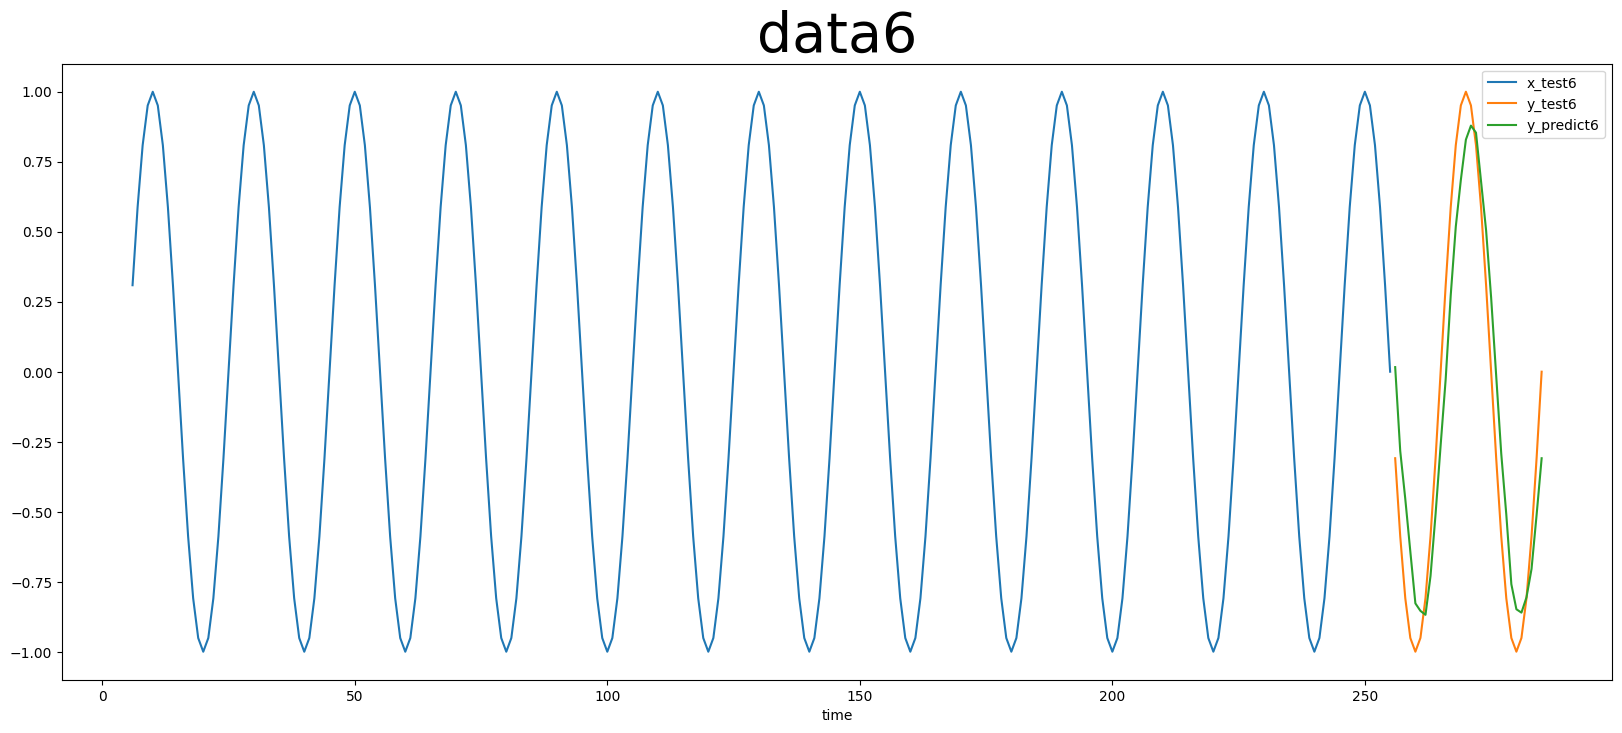

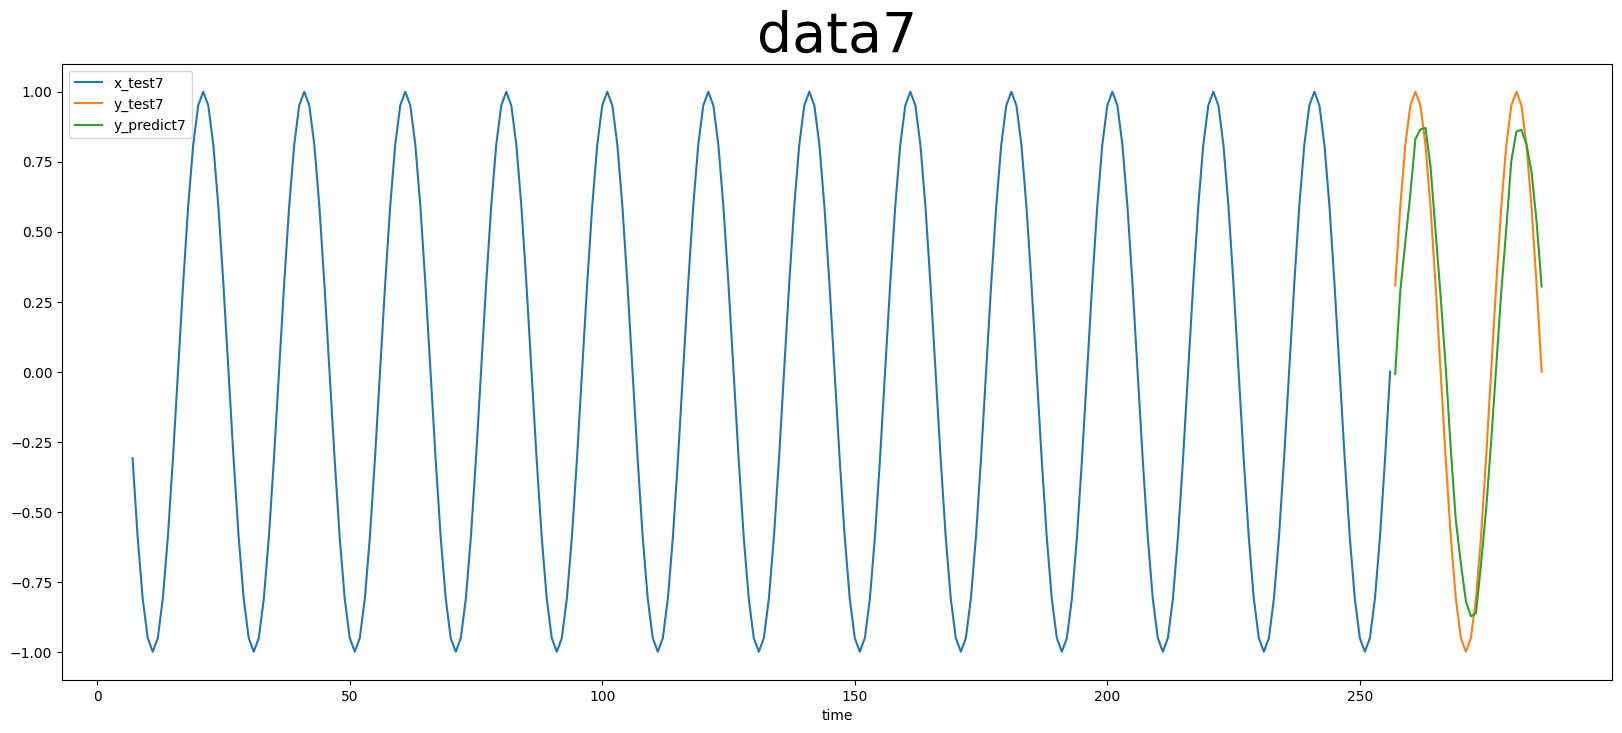

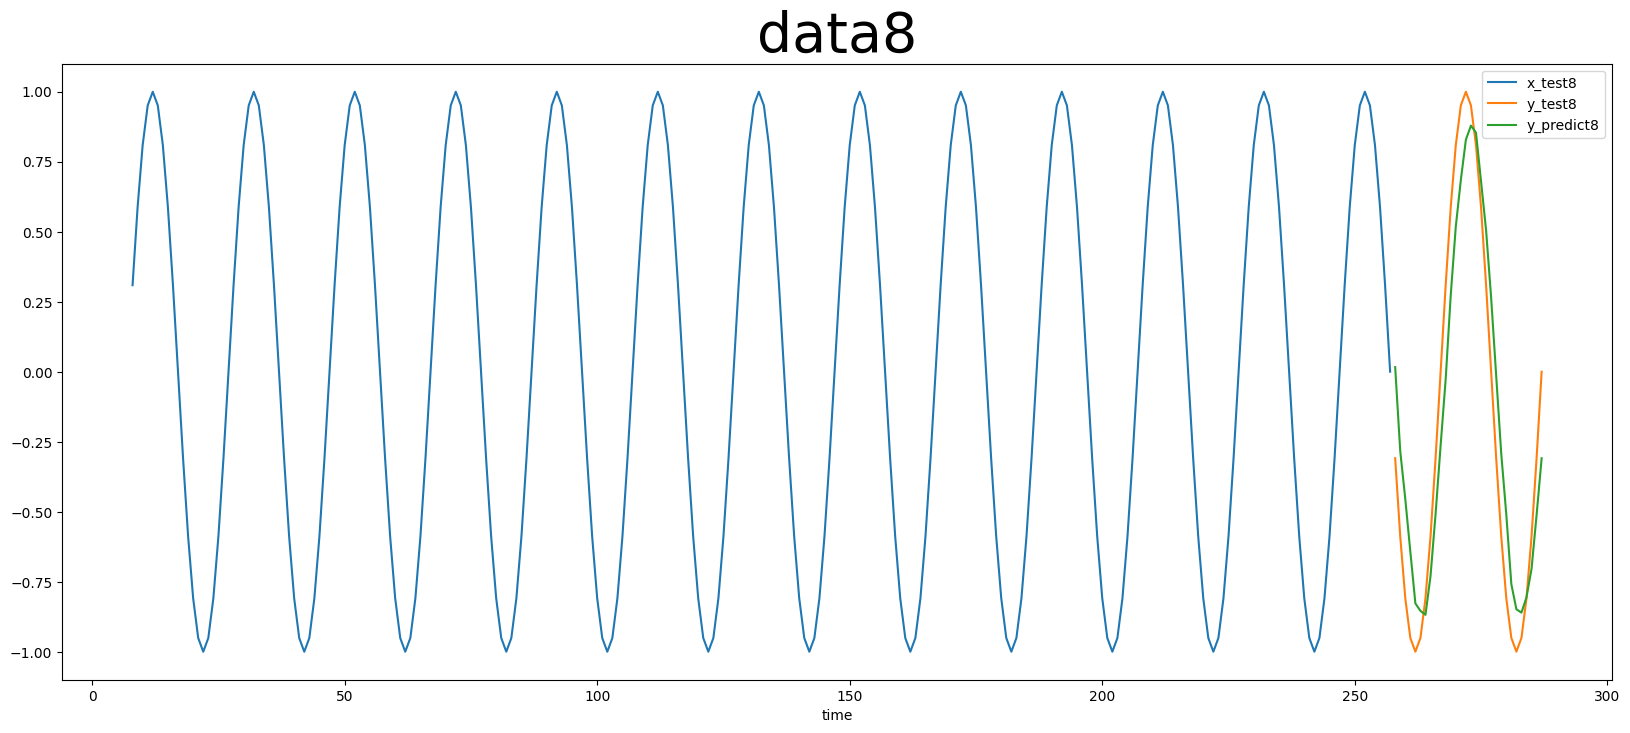

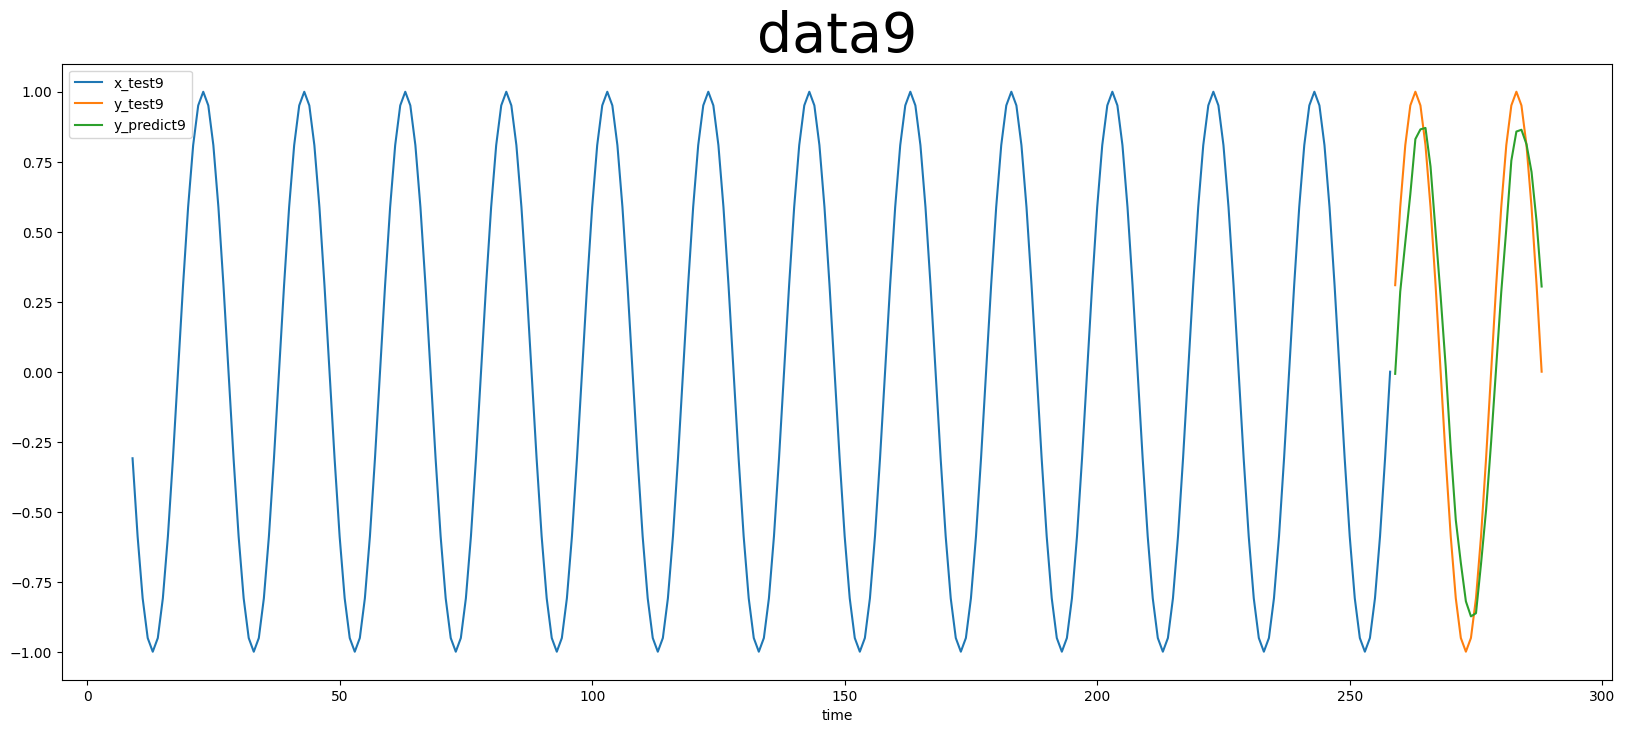

In [32]:
for num in range(0, 10, 1):
    plt.figure(figsize=(20, 8))
    for i in range(num, num+1):
        start = i
        singal = x_test[start]
        plt.plot(range(start,len(singal)+start), singal, label=f"x_test{i}")
    for i in range(num, num+1):
        start = i
        singal = y_test[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_test{i}")
    for i in range(num, num+1):
        start = i
        singal = predicted_prices[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_predict{i}")
    plt.xlabel("time")
    plt.title(f"data{i}", fontsize=40)
    plt.legend()
    plt.show()

In [93]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valley'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valley'


In [94]:
predicted_prices.shape[1]

30

In [116]:
def find_signal_pv_function(signal_souce, pv_range, test_data, slide):
    pd.options.mode.chained_assignment = None
    signal = {}
    for i in range(0, predicted_prices.shape[0]):
        data = pd.Series(signal_souce[i])
        signal[i] = pd.DataFrame()
        signal[i]['Close'] = data
        signal[i].index = test_data.index[range(i*slide, i*slide+predicted_prices.shape[1])]
        signal[i]['peaks'] = pd.Series(dtype='float64')
        signal[i]['valleys'] = pd.Series(dtype='float64')
        signal[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(data)):
            if idx < pv_range and  idx > 0:
                if data[idx] == data.iloc[0:pv_range*2+1].max():
                    signal[i]['peaks'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[0:pv_range*2+1].min():
                    signal[i]['valleys'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'valley'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                signal[i]['peaks'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'peak'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                signal[i]['valleys'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'valley'
    return signal


In [117]:
pv_range = 2
test_data['Close'] = actual_prices
find_data_pv_CL_function(test_data, pv_range)
processed_signal = find_signal_pv_function(predicted_prices, pv_range, test_data, slide)

In [118]:
processed_signal

{0:                Close     peaks   valleys      pv
 Date                                            
 2019-01-02  0.016467       NaN       NaN     NaN
 2019-01-03 -0.283141       NaN       NaN     NaN
 2019-01-04 -0.454213       NaN       NaN     NaN
 2019-01-07 -0.642344       NaN       NaN     NaN
 2019-01-08 -0.827306       NaN       NaN     NaN
 2019-01-09 -0.854082       NaN       NaN     NaN
 2019-01-10 -0.868122       NaN -0.868122  valley
 2019-01-11 -0.729193       NaN       NaN     NaN
 2019-01-14 -0.508068       NaN       NaN     NaN
 2019-01-15 -0.262812       NaN       NaN     NaN
 2019-01-16 -0.026415       NaN       NaN     NaN
 2019-01-17  0.273488       NaN       NaN     NaN
 2019-01-18  0.517942       NaN       NaN     NaN
 2019-01-22  0.684691       NaN       NaN     NaN
 2019-01-23  0.828750       NaN       NaN     NaN
 2019-01-24  0.878907  0.878907       NaN    peak
 2019-01-25  0.853730       NaN       NaN     NaN
 2019-01-28  0.680174       NaN       NaN     N

In [119]:
def find_signal_lead_train_function(data, processed_signal):
    for p in processed_signal:
        data = test_data.loc[processed_signal[p].index[0]:processed_signal[p].index[-1]]
        processing_signal = processed_signal[p]
        p_data = pd.DataFrame(
            {'peaks': data['peaks'], 'count': range(len(data))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data['valleys'], 'count': range(len(data))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[p]['lead'] = pd.Series(dtype='float64')
        processed_signal[p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
        processed_signal[p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']

In [120]:
find_signal_lead_train_function(test_data, processed_signal)

In [121]:
test_data

,Open,High,Low,Close,Adj Close,Volume,peaks,valleys,pv
Date,,,,,,,,,
2019-01-02,2476.959961,2519.489990,2467.469971,-0.305995,2510.030029,3733160000,NaN,NaN,NaN
2019-01-03,2491.919922,2493.139893,2443.959961,-0.584763,2447.889893,3858830000,NaN,NaN,NaN
2019-01-04,2474.330078,2538.070068,2474.330078,-0.805994,2531.939941,4234140000,NaN,NaN,NaN
2019-01-07,2535.610107,2566.159912,2524.560059,-0.948033,2549.689941,4133120000,NaN,NaN,NaN
2019-01-08,2568.110107,2579.820068,2547.560059,-0.996976,2574.409912,4120060000,NaN,-0.996976,valley
...,...,...,...,...,...,...,...,...,...
2019-06-24,2951.419922,2954.919922,2944.050049,0.003093,2945.350098,3136960000,NaN,NaN,NaN
2019-06-25,2945.780029,2946.520020,2916.010010,-0.305923,2917.379883,3579430000,NaN,NaN,NaN
2019-06-26,2926.070068,2932.590088,2912.989990,-0.584691,2913.780029,3511350000,NaN,NaN,NaN


In [122]:
processed_signal

{0:                Close     peaks   valleys      pv  lead
 Date                                                  
 2019-01-02  0.016467       NaN       NaN     NaN   NaN
 2019-01-03 -0.283141       NaN       NaN     NaN   NaN
 2019-01-04 -0.454213       NaN       NaN     NaN   NaN
 2019-01-07 -0.642344       NaN       NaN     NaN   NaN
 2019-01-08 -0.827306       NaN       NaN     NaN   NaN
 2019-01-09 -0.854082       NaN       NaN     NaN   NaN
 2019-01-10 -0.868122       NaN -0.868122  valley  -2.0
 2019-01-11 -0.729193       NaN       NaN     NaN   NaN
 2019-01-14 -0.508068       NaN       NaN     NaN   NaN
 2019-01-15 -0.262812       NaN       NaN     NaN   NaN
 2019-01-16 -0.026415       NaN       NaN     NaN   NaN
 2019-01-17  0.273488       NaN       NaN     NaN   NaN
 2019-01-18  0.517942       NaN       NaN     NaN   NaN
 2019-01-22  0.684691       NaN       NaN     NaN   NaN
 2019-01-23  0.828750       NaN       NaN     NaN   NaN
 2019-01-24  0.878907  0.878907       NaN    

In [123]:
def get_first_lead_function(processed_signal):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        temp = processed_signal[i].loc[list(
            processed_signal[i]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [124]:
first_date, lead, pv = get_first_lead_function(processed_signal)

In [125]:
def built_result_table_function(processed_signal, lead, pv):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv'])
    for i in processed_signal:
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
        result_table.loc[i, 's_date'] = processed_signal[i].index[0]
    return result_table


In [126]:
result_table = built_result_table_function(processed_signal, lead, pv)
print(result_table)

                s_date t_date lead ans_date      pv
0  2019-01-02 00:00:00    NaN -2.0      NaN  valley
1  2019-01-16 00:00:00    NaN -2.0      NaN    peak
2  2019-01-31 00:00:00    NaN -2.0      NaN  valley
3  2019-02-14 00:00:00    NaN -2.0      NaN    peak
4  2019-03-01 00:00:00    NaN -2.0      NaN  valley
5  2019-03-15 00:00:00    NaN -2.0      NaN    peak
6  2019-03-29 00:00:00    NaN -2.0      NaN  valley
7  2019-04-12 00:00:00    NaN -2.0      NaN    peak
8  2019-04-29 00:00:00    NaN -2.0      NaN  valley
9  2019-05-13 00:00:00    NaN -2.0      NaN    peak


In [127]:
def result_table_process_function(result_table, data, first_date):
    for i in result_table.index:
        t_date = first_date[i]
        result_table.loc[i, 't_date'] = t_date
        ans = data.iloc[int(data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [128]:
result_table_process_function(result_table, test_data, first_date)

In [129]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [130]:
final_error = compute_final_error_function(result_table)

In [131]:
def evaluate_model(processed_signal, test_data, first_date, lead, pv):
    result_table = built_result_table_function(processed_signal, lead, pv)
    result_table_process_function(result_table, test_data, first_date)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error

In [132]:
result_table, final_error = evaluate_model(processed_signal, test_data, first_date, lead, pv)

In [133]:
print(result_table)

                s_date               t_date lead             ans_date      pv
0  2019-01-02 00:00:00  2019-01-10 00:00:00 -2.0  2019-01-08 00:00:00  valley
1  2019-01-16 00:00:00  2019-01-25 00:00:00 -2.0  2019-01-23 00:00:00    peak
2  2019-01-31 00:00:00  2019-02-08 00:00:00 -2.0  2019-02-06 00:00:00  valley
3  2019-02-14 00:00:00  2019-02-25 00:00:00 -2.0  2019-02-21 00:00:00    peak
4  2019-03-01 00:00:00  2019-03-11 00:00:00 -2.0  2019-03-07 00:00:00  valley
5  2019-03-15 00:00:00  2019-03-25 00:00:00 -2.0  2019-03-21 00:00:00    peak
6  2019-03-29 00:00:00  2019-04-08 00:00:00 -2.0  2019-04-04 00:00:00  valley
7  2019-04-12 00:00:00  2019-04-23 00:00:00 -2.0  2019-04-18 00:00:00    peak
8  2019-04-29 00:00:00  2019-05-07 00:00:00 -2.0  2019-05-03 00:00:00  valley
9  2019-05-13 00:00:00  2019-05-21 00:00:00 -2.0  2019-05-17 00:00:00    peak


In [134]:
print(f'final_error = {final_error}')

final_error = 2.0


In [135]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data= test_data.drop(test_data[test_data.index > date_list[-1]].index)
    axes[0].plot(test_data.index, test_data['Close'], 'gray', label='data', linewidth=3)
    axes[0].plot(test_data.index, test_data['peaks'],
                '^', c='royalblue', label='peaks')
    axes[0].plot(test_data.index, test_data['valleys'], 'v',
                c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

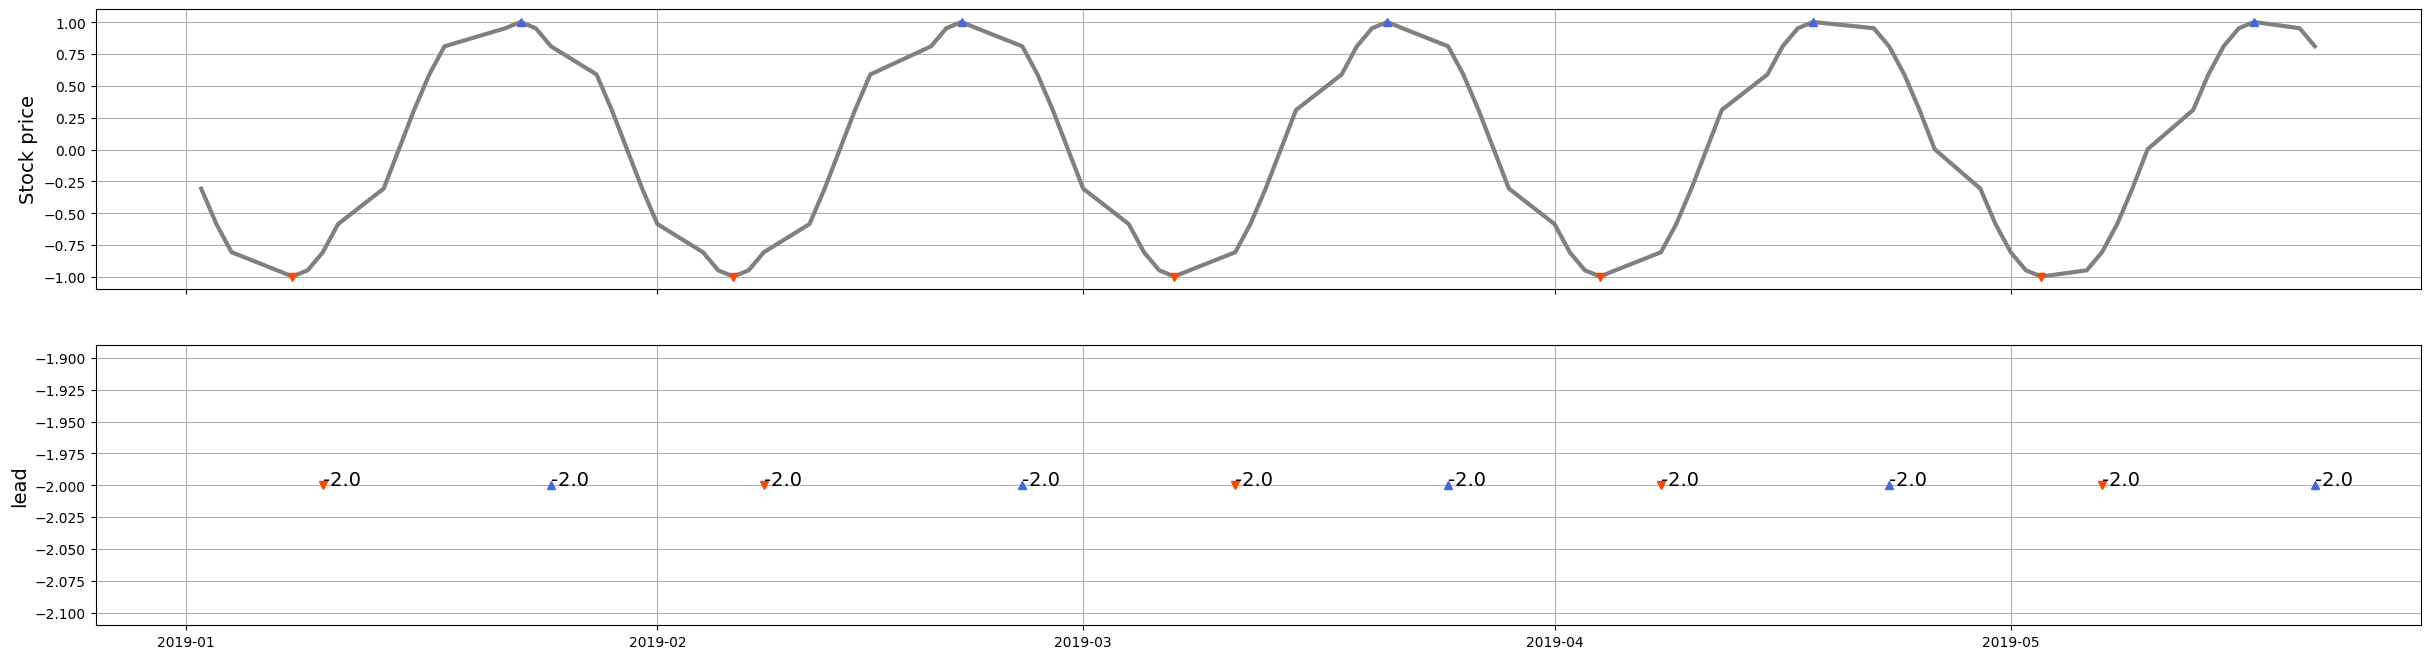

In [136]:
draw_plot_result_table(test_data, data, result_table, pv_range)